# X_ray 이미지로 폐렴 진단하기
* 의학용 이미지는 데이터 수가 적어 딥러닝에 적용하기 어려운 문제가 있다.
* 그래서 데이터를 augmentation하여 데이터의 다양성을 늘려 문제를 해결하는 시도가 많다.
* 하지만 의학용 딥러닝 모델은 사람의 생명을 좌지우지 하는 문제를 다루기 때문에 augmentation 할 때 신중해야 한다.

In [1]:
 #! wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1li6ctqAvGFgIGMSt-mYrLoM_tbYkzqdO' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1li6ctqAvGFgIGMSt-mYrLoM_tbYkzqdO" -O chest_xray.zip && rm -rf /tmp/cookies.txt

In [2]:
#! unzip -qq chest_xray.zip


## Step 1. 실험환경 Set-up
* 패키지(라이브러리)들을 import 하기

In [3]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE 
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel') # 원래의 노드의 코드 
#ROOT_PATH = os.getcwd() 
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' 
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16 #한번에 계산할 크기
EPOCHS = 5 #반복횟수 원래 25

print(ROOT_PATH) #코랩의 현재 주소
print(TRAIN_PATH)
print(AUTOTUNE)

/aiffel/aiffel
/aiffel/aiffel/chest_xray/data/train/*/*
-1


In [4]:
import time
import glob
starts = time.time() #시간 측정을 위해 시작
train_filenames = tf.io.gfile.glob(TRAIN_PATH) #경로로부터 파일이름 획득
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)
ends = time.time() #끝

starts2 =time.time()
train_filenames = glob.glob(TRAIN_PATH) #똑같이 경로로 부터 파일이름 획득
test_filenames = glob.glob(TEST_PATH)
val_filenames = glob.glob(VAL_PATH)
ends2 = time.time()

print('tf.io.gfile.glob = ',str(ends - starts)[:8],'s') #tf.io.gfile.glob의 걸린시간
print('glob.glob = ', str(ends2 - starts2)[:8],'s')
# glob의 걸린시간 이게 2.5배 이상 빠르네요

tf.io.gfile.glob =  0.721731 s
glob.glob =  0.020900 s


* 앞으로 필요한 변수들을 생성

## Step 2. 데이터 준비하기

### Step 2-1. 8:2 분할

In [5]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


### Step 2-2. 이미지 수 확인

In [6]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-0618-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person399_virus_793.jpeg


In [7]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename]) #파일 이름에 정상이면 길이에 더해서 저장
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename]) #페렴이면
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA)) #왜 굳이 str로 출력했는지는 모르겠다

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


* 정상보다 폐렴 이미지 수가 3배 더 많다.

In [8]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)
#tf.data.Dataset.from_tensor_slices 함수는 tf.data.Dataset 를 생성하는 함수로 입력된 텐서로부터 slices를 생성합니다.
# 예를 들어 MNIST의 학습데이터 (60000, 28, 28)가 입력되면, 60000개의 slices로 만들고 각각의 slice는 28×28의 이미지 크기를 갖게 됩니다.

[카디널리티란?](https://itholic.github.io/database-cardinality/)
대충 이해하기론 상대적으로 unique하면 카디널리티가 높다

In [9]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()#데이터의 카디널리티값을 리턴
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy() #텐서는 .numpy() 메서드(method)를 호출하여 넘파이 배열로 변환할 수 있습니다
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 4185
Validating images count: 1047


In [10]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1] #2~마지막까지 파일 경로를 os.path.sep(OS별 파일 경로 나는 문자)를 이용해 split합니다.
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/chest_xray/data/train/*"))])
print(CLASS_NAMES)

['PNEUMONIA' 'NORMAL']


### Step 2-3. 라벨링 변경
* 정상 NORMAL -> False
* 폐렴 PNEUMONIA -> True

In [11]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   
# 폐렴이면 1값 반환, 아니면 0하게 합니다.

### Step 2-4. 이미지 사이즈 축소
* float 타입으로 변경

In [12]:
def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels=3)
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

### Step 2-5. train, validation 데이터셋 만들기

In [13]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE) #num_parallel_calls여러 병렬 데이터셋을 불러오고, 파일을 여는 데 기다리는 시간을 단축한다

In [14]:
for image, label in train_ds.take(1): #train_ds.take(1)은 하나의 데이터만 가져온다는 의미입니다.
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [15]:
test_list_ds = tf.data.Dataset.list_files(str(ROOT_PATH + '/chest_xray/data/test/*/*'))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


#원본 
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    #shuffle()을 사용하며 고정 크기 버퍼를 유지하고 해당 버퍼에서 무작위로 균일하게 다음 요소를 선택합니다. 
    ds = ds.repeat()
    #repeat()를 사용하면 epoch를 진행하면서 여러 번 데이터셋을 불러오게 되는데, 
    #이때 repeat()를 사용한 데이터셋의 경우 여러 번 데이터셋을 사용할 수 있게 해줍니다.
    ds = ds.batch(BATCH_SIZE)
    #batch()를 사용하면 BATCH_SIZE에서 정한 만큼의 배치
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    #prefetch()를 사용하면 학습 데이터를 나눠서 읽어오기 때문에,
    #첫 번째 데이터를 GPU에서 학습하는 동안 두 번째 데이터를 CPU에서 준비할 수 있어
    #리소스의 유휴 상태를 줄일 수 있습니다.
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

이미지 수 증강 좌우반전

In [16]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)  # 랜덤하게 좌우를 반전합니다.
    return image,label
#이미지 증강
def prepare_for_training(ds, shuffle_buffer_size=1000):
    # augment 적용 부분이 배치처리 함수에 추가되었습니다.
    ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    print("증강 후:",len(ds))
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds
#배치화는 레귤러리제이션 효과가 있다


print("증강전 수", len(train_ds))
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

image_batch, label_batch = next(iter(train_ds)) 

증강전 수 4185
증강전 후 16


## Step 3. 데이터 시각화

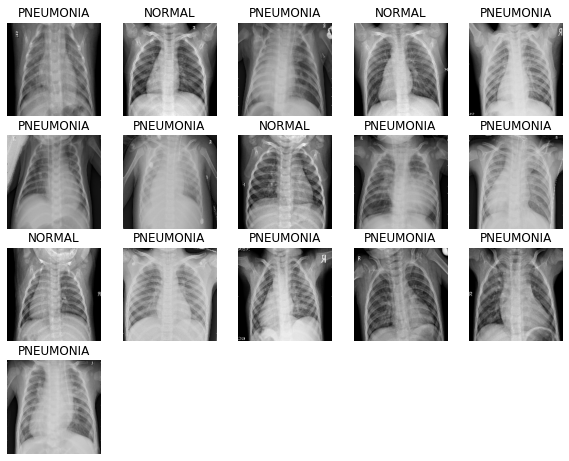

In [17]:
#image_batch, label_batch = next(iter(train_ds)) 
#for문처럼 train_ds로 iter를 만들고 넥스트로 train_ds가 없을때까지 반복

def show_batch(image_batch, label_batch): #한번에 연산할 양 16개
    plt.figure(figsize=(10,10))
    for n in range(16):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

show_batch(image_batch.numpy(), label_batch.numpy())

showbatch로 열심히 증강된 이미지 비교를 해보려했으나 실패

증강된 이후 셔플해버려서 결과가 안남았다

## Step 4. CNN 모델링
### Step 4-1. Convolution block 만들기

In [19]:
def conv_block(filters): #블럭 함수화 하니 보기도 좋고 좋네요
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

### Step 4-2. Dense Block 만들기

In [20]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

### Step 4-3. Batch Normalization, Dropout적용 CNN 모델 설계 

In [21]:
def build_model(drop=0.2):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.3),#원래 0.2
        
        conv_block(256),
        tf.keras.layers.Dropout(0.3),#원래 0.2
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid') #2진 분류는 시그모이드
        
    ])
    
    return model

## Step 5. 데이터 imbalance 처리

In [22]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0 #폐렴 사진수가 3배가 가까이 커서 가중치를 따로 둠

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.95
Weight for class 1: 0.67


## Step 6. 모델 훈련

In [23]:
with tf.device('/GPU:0'):
    model = build_model()
    model.summary()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
sequential (Sequential)      (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_1 (Sequential)    (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_2 (Sequential)    (None, 11, 11, 128)       27072     
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 128)      

파이썬 with
보통 프로그램은 파일에 접근해서 파일 내용등을 읽고 쓰고 삭제하고 수정하는 등등 무언가의 일을 수행한 뒤 그 파일을 해제(close) 하는 패턴을 따른다. 예를 들어 우리가 엑셀 파일을 열었는데 그 엑셀파일을 열고 있는 동안에는 다른 프로그램에서 엑셀 파일에 접근할 수 없게 된다. 거두절미하고 파일을 열었으면 닫아주는 일을 빼먹지 말아야 한다는 것이다. 보통은 close() 등과 같은 메소드를 사용하지만 여기에는 숨은 문제점이 있다. 파일 처리를 수행하는 도중에 오류가 발생하게 되면 close() 문을 실행할 수 없고 그렇게 되면 이 파일은 영원히 닫을 수가 없게 된다.  with 문은 그 구문을 실행했을 때 오류가 발생하든 안하든 마지막에 close 를 해주도록 하는 것이다.

### Step 6-1. 모델 fit

In [25]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks = [es]
    )

Epoch 1/5
261/261 [==============================] - 86s 230ms/step - loss: 0.6126 - accuracy: 0.6699 - precision: 0.8865 - recall: 0.6352 - val_loss: 0.6933 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/5
261/261 [==============================] - 59s 227ms/step - loss: 0.2543 - accuracy: 0.8933 - precision: 0.9725 - recall: 0.8812 - val_loss: 1.6376 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/5
261/261 [==============================] - 60s 229ms/step - loss: 0.2263 - accuracy: 0.9122 - precision: 0.9719 - recall: 0.9075 - val_loss: 0.2991 - val_accuracy: 0.8481 - val_precision: 0.8288 - val_recall: 1.0000
Epoch 4/5
261/261 [==============================] - 60s 229ms/step - loss: 0.1665 - accuracy: 0.9336 - precision: 0.9777 - recall: 0.9325 - val_loss: 0.1375 - val_accuracy: 0.9423 - val_precision: 0.9292 - val_recall: 0.9974
Epoch 5/5
261/261 [==============================] - 60s 231ms/step - loss: 0.1659 - accuracy: 0

## Step 7. 결과 확인

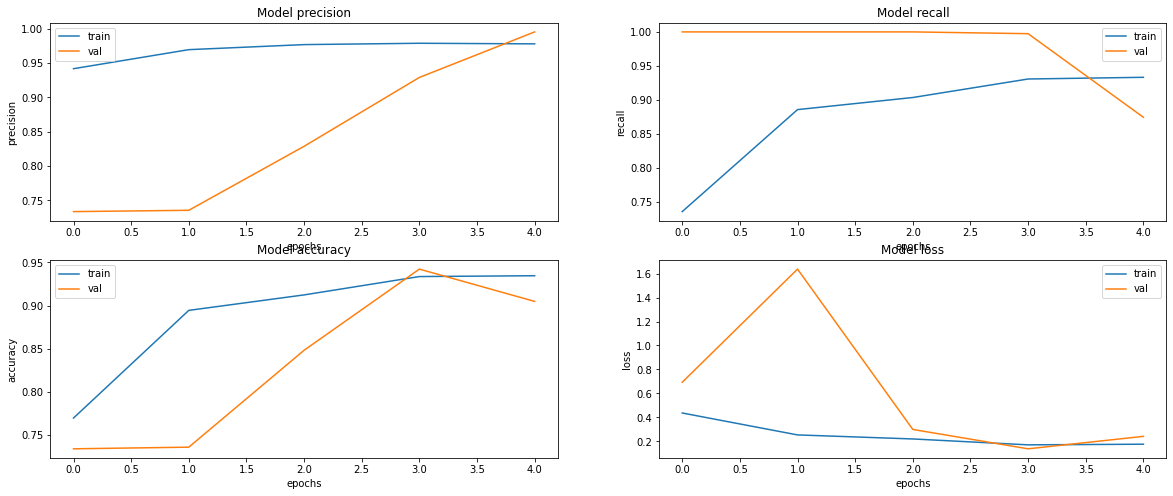

In [26]:
fig, ax = plt.subplots(2, 2, figsize=(20, 8))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [28]:
def view(history):
    fig, ax = plt.subplots(2, 2, figsize=(20, 8))
    ax = ax.ravel()
    
    for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])

# 1차 시험

In [27]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 6s 142ms/step - loss: 0.3773 - accuracy: 0.8558 - precision: 0.8555 - recall: 0.9256


음 일단 드롭아웃 30퍼,이미지 애그먼트, 에폭이 5갠데 운이 좋았는지 목표치 0.85가 넘었다 일단 박제

# 2차 시험 드롭아웃 20퍼

In [29]:
def build_model(drop=0.2):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(drop),#원래 0.2
        
        conv_block(256),
        tf.keras.layers.Dropout(drop),#원래 0.2
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid') #2진 분류는 시그모이드
        
    ])
    
    return model

In [30]:
with tf.device('/GPU:0'):
    model = build_model() #이번 드롭아웃은 20퍼 원본
    model.summary()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
sequential_8 (Sequential)    (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_9 (Sequential)    (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_10 (Sequential)   (None, 11, 11, 128)       27072     
_________________________________________________________________
dropout_5 (Dropout)          (None, 11, 11, 128)     

In [31]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
EPOCHS = 25 #이번엔 학습좀 해본다

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks = [es]
    )

Epoch 1/25
261/261 [==============================] - 71s 229ms/step - loss: 0.5397 - accuracy: 0.7294 - precision: 0.9163 - recall: 0.6984 - val_loss: 0.6755 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 59s 226ms/step - loss: 0.2302 - accuracy: 0.9012 - precision: 0.9744 - recall: 0.8911 - val_loss: 1.2239 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 59s 228ms/step - loss: 0.1930 - accuracy: 0.9200 - precision: 0.9736 - recall: 0.9163 - val_loss: 0.6490 - val_accuracy: 0.7452 - val_precision: 0.7430 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 60s 229ms/step - loss: 0.1863 - accuracy: 0.9320 - precision: 0.9804 - recall: 0.9280 - val_loss: 0.0966 - val_accuracy: 0.9644 - val_precision: 0.9631 - val_recall: 0.9895
Epoch 5/25
261/261 [==============================] - 60s 230ms/step - loss: 0.1814 - accura

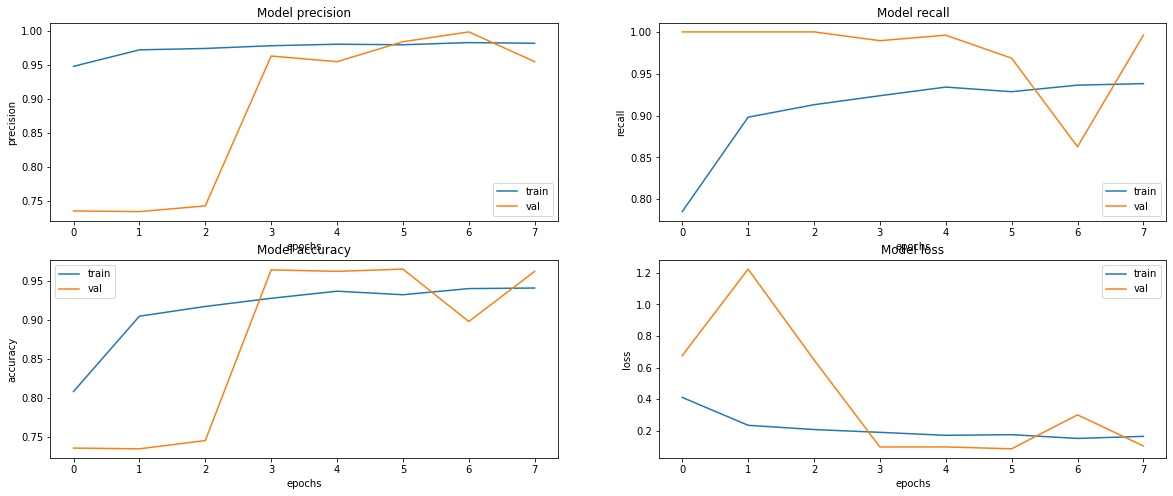

In [32]:
view(history)

In [33]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 6s 138ms/step - loss: 0.9440 - accuracy: 0.7099 - precision: 0.6837 - recall: 0.9974


드롭아웃은 여태 학습한 데이터 피쳐를 날려서 안정적인 학습을 방해한다   
하지만 그게 실전 테스트에 도움이 되는거 같다

# 3차 드롭아웃 0.5 에폭 25

In [35]:
with tf.device('/GPU:0'):
    model = build_model(drop = 0.5) #이번 드롭아웃은 50퍼
    model.summary()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
sequential_16 (Sequential)   (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_17 (Sequential)   (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_18 (Sequential)   (None, 11, 11, 128)       27072     
_________________________________________________________________
dropout_10 (Dropout)         (None, 11, 11, 128)     

In [36]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
EPOCHS = 25 #이번엔 학습좀 해본다

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        callbacks = [es]
    )

Epoch 1/25
261/261 [==============================] - 71s 229ms/step - loss: 0.7265 - accuracy: 0.6145 - precision: 0.8409 - recall: 0.5889 - val_loss: 0.7554 - val_accuracy: 0.7375 - val_precision: 0.7375 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 60s 230ms/step - loss: 0.3000 - accuracy: 0.8746 - precision: 0.9661 - recall: 0.8608 - val_loss: 1.6684 - val_accuracy: 0.7375 - val_precision: 0.7375 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 60s 229ms/step - loss: 0.2555 - accuracy: 0.8883 - precision: 0.9671 - recall: 0.8807 - val_loss: 0.1354 - val_accuracy: 0.9375 - val_precision: 0.9344 - val_recall: 0.9844
Epoch 4/25
261/261 [==============================] - 60s 229ms/step - loss: 0.1907 - accuracy: 0.9269 - precision: 0.9813 - recall: 0.9191 - val_loss: 0.1544 - val_accuracy: 0.9442 - val_precision: 0.9889 - val_recall: 0.9346
Epoch 5/25
261/261 [==============================] - 60s 232ms/step - loss: 0.2084 - accura

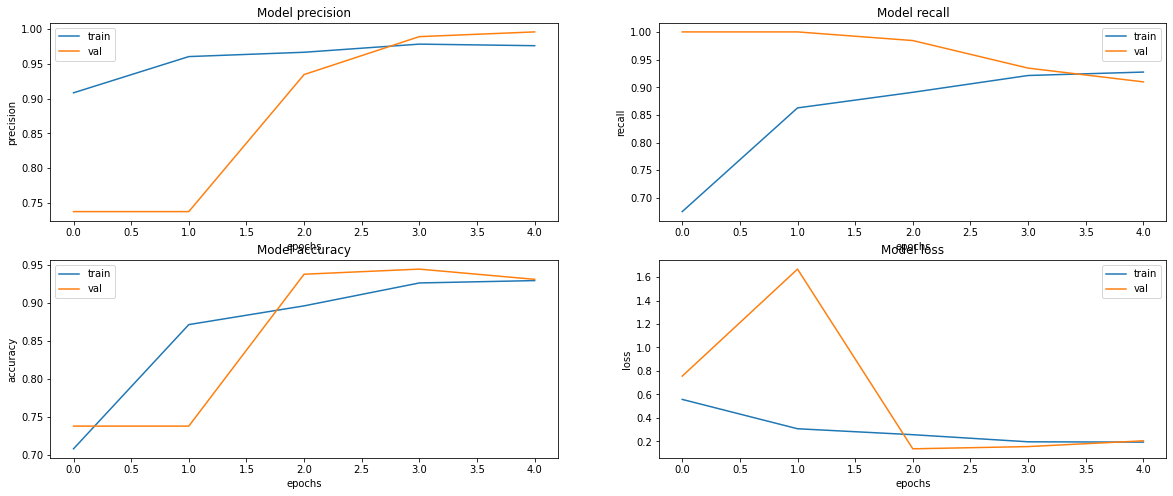

In [37]:
view(history)

In [38]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 6s 143ms/step - loss: 0.4197 - accuracy: 0.8462 - precision: 0.8311 - recall: 0.9462


# 4차 얼리스톱 꺼보기 기타 3차와 동일

In [39]:
with tf.device('/GPU:0'):
    model = build_model(drop = 0.5) #이번 드롭아웃은 50퍼
    model.summary()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
sequential_24 (Sequential)   (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_25 (Sequential)   (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_26 (Sequential)   (None, 11, 11, 128)       27072     
_________________________________________________________________
dropout_15 (Dropout)         (None, 11, 11, 128)     

In [40]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
EPOCHS = 25 #이번엔 학습좀 해본다

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        #callbacks = [es]
    )

Epoch 1/25
261/261 [==============================] - 72s 231ms/step - loss: 0.6760 - accuracy: 0.6788 - precision: 0.8754 - recall: 0.6634 - val_loss: 0.5898 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 60s 229ms/step - loss: 0.3392 - accuracy: 0.8566 - precision: 0.9574 - recall: 0.8458 - val_loss: 0.9959 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 60s 229ms/step - loss: 0.2803 - accuracy: 0.8793 - precision: 0.9637 - recall: 0.8718 - val_loss: 0.5632 - val_accuracy: 0.7865 - val_precision: 0.7764 - val_recall: 0.9974
Epoch 4/25
261/261 [==============================] - 60s 232ms/step - loss: 0.2214 - accuracy: 0.9083 - precision: 0.9743 - recall: 0.9013 - val_loss: 0.1572 - val_accuracy: 0.9490 - val_precision: 0.9541 - val_recall: 0.9778
Epoch 5/25
261/261 [==============================] - 61s 235ms/step - loss: 0.2041 - accura

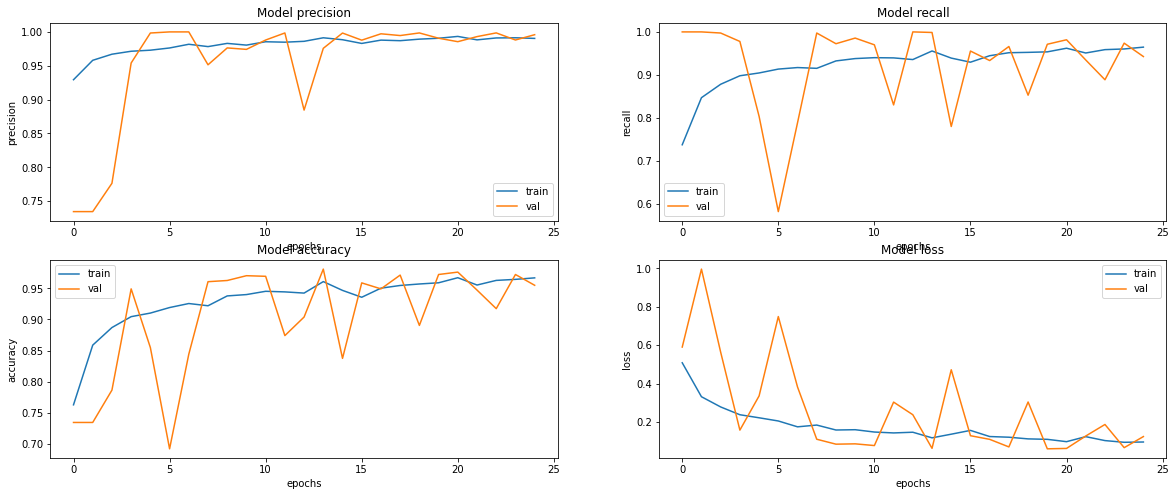

In [41]:
view(history)

In [42]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 6s 149ms/step - loss: 0.8288 - accuracy: 0.8237 - precision: 0.7979 - recall: 0.9615


드롭아웃은 계속 흔들리더라도 나은 결과적으로는 나은 방향으로 움직이는걸로 보인다

# 마지막 확인용 드롭 30퍼 25에폭 논얼리스탑

In [43]:
with tf.device('/GPU:0'):
    model = build_model(drop = 0.3) #이번 드롭아웃은 50퍼
    model.summary()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 180, 180, 16)      2320      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
sequential_32 (Sequential)   (None, 45, 45, 32)        2160      
_________________________________________________________________
sequential_33 (Sequential)   (None, 22, 22, 64)        7392      
_________________________________________________________________
sequential_34 (Sequential)   (None, 11, 11, 128)       27072     
_________________________________________________________________
dropout_20 (Dropout)         (None, 11, 11, 128)     

In [44]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
EPOCHS = 25 #이번엔 학습좀 해본다

with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
        #callbacks = [es]
    )

Epoch 1/25
261/261 [==============================] - 71s 228ms/step - loss: 0.5684 - accuracy: 0.6982 - precision: 0.9213 - recall: 0.6479 - val_loss: 0.5807 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 60s 229ms/step - loss: 0.2879 - accuracy: 0.8837 - precision: 0.9707 - recall: 0.8696 - val_loss: 0.7320 - val_accuracy: 0.7375 - val_precision: 0.7375 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 59s 228ms/step - loss: 0.2371 - accuracy: 0.9088 - precision: 0.9735 - recall: 0.9027 - val_loss: 1.2207 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 60s 230ms/step - loss: 0.2082 - accuracy: 0.9157 - precision: 0.9799 - recall: 0.9054 - val_loss: 0.2190 - val_accuracy: 0.9269 - val_precision: 0.9873 - val_recall: 0.9124
Epoch 5/25
261/261 [==============================] - 60s 230ms/step - loss: 0.2041 - accura

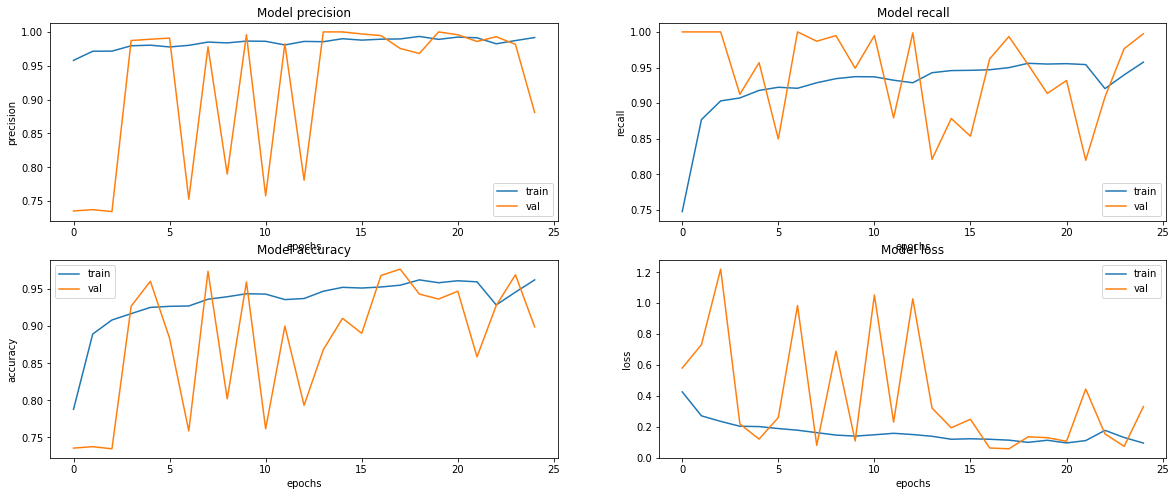

In [45]:
view(history)

In [46]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 6s 146ms/step - loss: 1.9143 - accuracy: 0.6811 - precision: 0.6632 - recall: 0.9949


실패에 가깝다 하필 드롭아웃으로 학습률 날아가는 순간에 정지되어 학습이 엉망이 된거같다

# 관찰록
관찰한 결과는 얼리스톱은 평상시 관심있는 수치를 모니터 함으로써 적절한 단계에서 학습을 정지해 주는 좋은 도구지만 드롭아웃 시도시 흔들리는 수치에서 적합한 학습을 방해하는 요소가 있다. 드롭아웃시 얼리스톱은 배제하거나 patient를 크게 줘야될걸로 보인다. 

드롭아웃은 중요한 피쳐를 날려먹으면서 학습정확도가 춤을 추듯 흔들린다. 하지만 그래프를 보면 결과적으로는 나은 방향을 향해 나아가서 꼭 필요하다. 무작위로 퍼센트 날리지 말고 가중치에 따른 드롭아웃 대한 고찰이 필요하다고 생각한다

드롭아웃 사용시에는 학습률이 이리저리 튀어서 좋은 순간에 좀 정지해야될것 같은데... 운빨만 믿고여러번 돌려야 되나 생각하게 된다. 또한 에폭이 많은 학습이 꼭 좋은건 아닌거 같다.

시험 결과를 정리해보니 낮은 학습횟수, 높은 드롭이 결과가 잘나왔다

# 시험 결과 정리

|No.|변경 하이퍼파라메터|최종시험 정확도|
|-|:-|-|
|1차 |드롭 0.3, 에폭 5 | 0.85|
|2차|드롭 0.2, 얼리스톱, 에폭 8|0.70|
|3차|드롭 0.5, 얼리스톱, 에폭 5|0.84|
|4차|드롭 0.5, 에폭 25|0.82|
|막차|드롭 0.3, 에폭 25|0.68|

Step 1. 실험환경 Set-up

거의 바꿔볼 수 있을 게 없을 것 같지만, Batch size, Epoch 등을 변경해볼 수 있을 것입니다.
Step 2. 데이터 준비하기

원본 데이터를 가져와서 전처리 및 배치 구성을 진행합니다.
의료 영상 이미지의 특성상 데이터는 언제나 충분하지 않습니다. 이를 극복할 수 있는 방법을 고민해 봅시다.

이전 실습에서 고려하지 않았던 augmentation 기법을 고려해 볼 수 있을 것입니다. 그러나 의료 영상인 경우, 일반적인 이미지 처리에서 사용하는 augmentation들이 항상 도움이 된다고 말할 수 없습니다. 특히 X-RAY 같은 의료 영상의 특성상, 육안으로도 구분하기 어려운 미묘한 차이에 더해진 노이즈 등 부수효과가 오히려 방해를 줄 수도 있기 때문입니다.
그래서 augmentation 도입은 신중해야 합니다.

만약 예를 들어 좌우 반전 정도의 augmentation만 도입

Step 3. 데이터 시각화

학습용 데이터를 시각화해서 확인해 봅니다.
만약 augmentation을 시도했다면 이후 실습 코드에 있는 show_batch() 함수를 통해 실제로 좌우 반전 등이 제대로 처리되었는지 확인해 봅시다.

Step 4. CNN 모델링

의료 영상 판독을 위해 실습에서 구현했던 model에서 다양한 것들을 바꾸어 가며 실험해볼 수 있습니다. Convolution filter, 채널 개수, activation, 모델 구조 등을 다양하게 바꾸어볼 수 있습니다.

그리고, 우리는 BatchNormalization과 Dropout을 한 모델 안에서 동시에 사용하는 특이한 구성을 실습했습니다.
이것은 일반적으로 잘 사용되는 형태는 아닙니다. 하지만 이미지 사이즈가 크고 데이터가 부족한 의료 영상에서는 실용적으로 간혹 좋은 성능을 보이기도 합니다. 만약 이 구성을 변경해 보면 어떤 효과가 발생하는지도 실험해 봅시다. BatchNormalization을 쓰거나 혹은 쓰지 않거나, Dropout을 쓰거나 혹은 쓰지 않거나 할 수 있습니다. 또, Dropout 비율을 변경해볼 수도 있습니다.

Step 5. 데이터 imbalance 처리

실습 코드에서 데이터의 imbalance 문제에 대처하기 위해 데이터 비율로 나누어진 class_weight를 설정해 주었습니다. 만약 이러한 처리를 생략한다면 어떻게 될까요? 또 recall을 강조하기 위해 폐렴 데이터를 잘 맞추는 것을 더 강화하는 효과를 만들어낼 수는 없을까요?

Step 6. 모델 훈련

loss 함수를 변경하기는 어렵겠지만, optimizer나 learning rate 등의 변화를 고려해볼 수 있을 것입니다.

Step 7. 결과 확인과 시각화

테스트 데이터로 훈련된 모델을 평가해 봅시다. 우선은 accuracy를 고려해야겠지만 의료 영상 모델의 특성상 recall도 중요합니다. 훈련과정의 history 그래프를 시각화해 보고, 학습 진행 양상을 면밀히 분석해 보는 것도 잊지 않도록 합시다.

Machine learning에서, ablation study는 "machine learning system의 building blocks을 제거해서 전체 성능에 미치는 효과에 대한 insight를 얻기 위한 과학적 실험"으로 정의할 수 있다

|No.|평가문항|	상세기준|
|-|:-|:-|
|1.| 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.|	모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.
|2.| 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.|	regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.
|3.| 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다.|	Accuracy 기준 85%에 도달하였다.

In [27]:
loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 6s 142ms/step - loss: 0.3773 - accuracy: 0.8558 - precision: 0.8555 - recall: 0.9256


loss, acc, prec, rec = model.evaluate(test_ds)

39/39 [==============================] - 6s 142ms/step - loss: 0.3773 - accuracy: 0.8558 - precision: 0.8555 - recall: 0.9256


음 일단 드롭아웃 0.3퍼,이미지 애그먼트, 에폭이 5갠데 운이 좋았는지 목표치 0.85가 넘었다 일단 박제